# BSD100

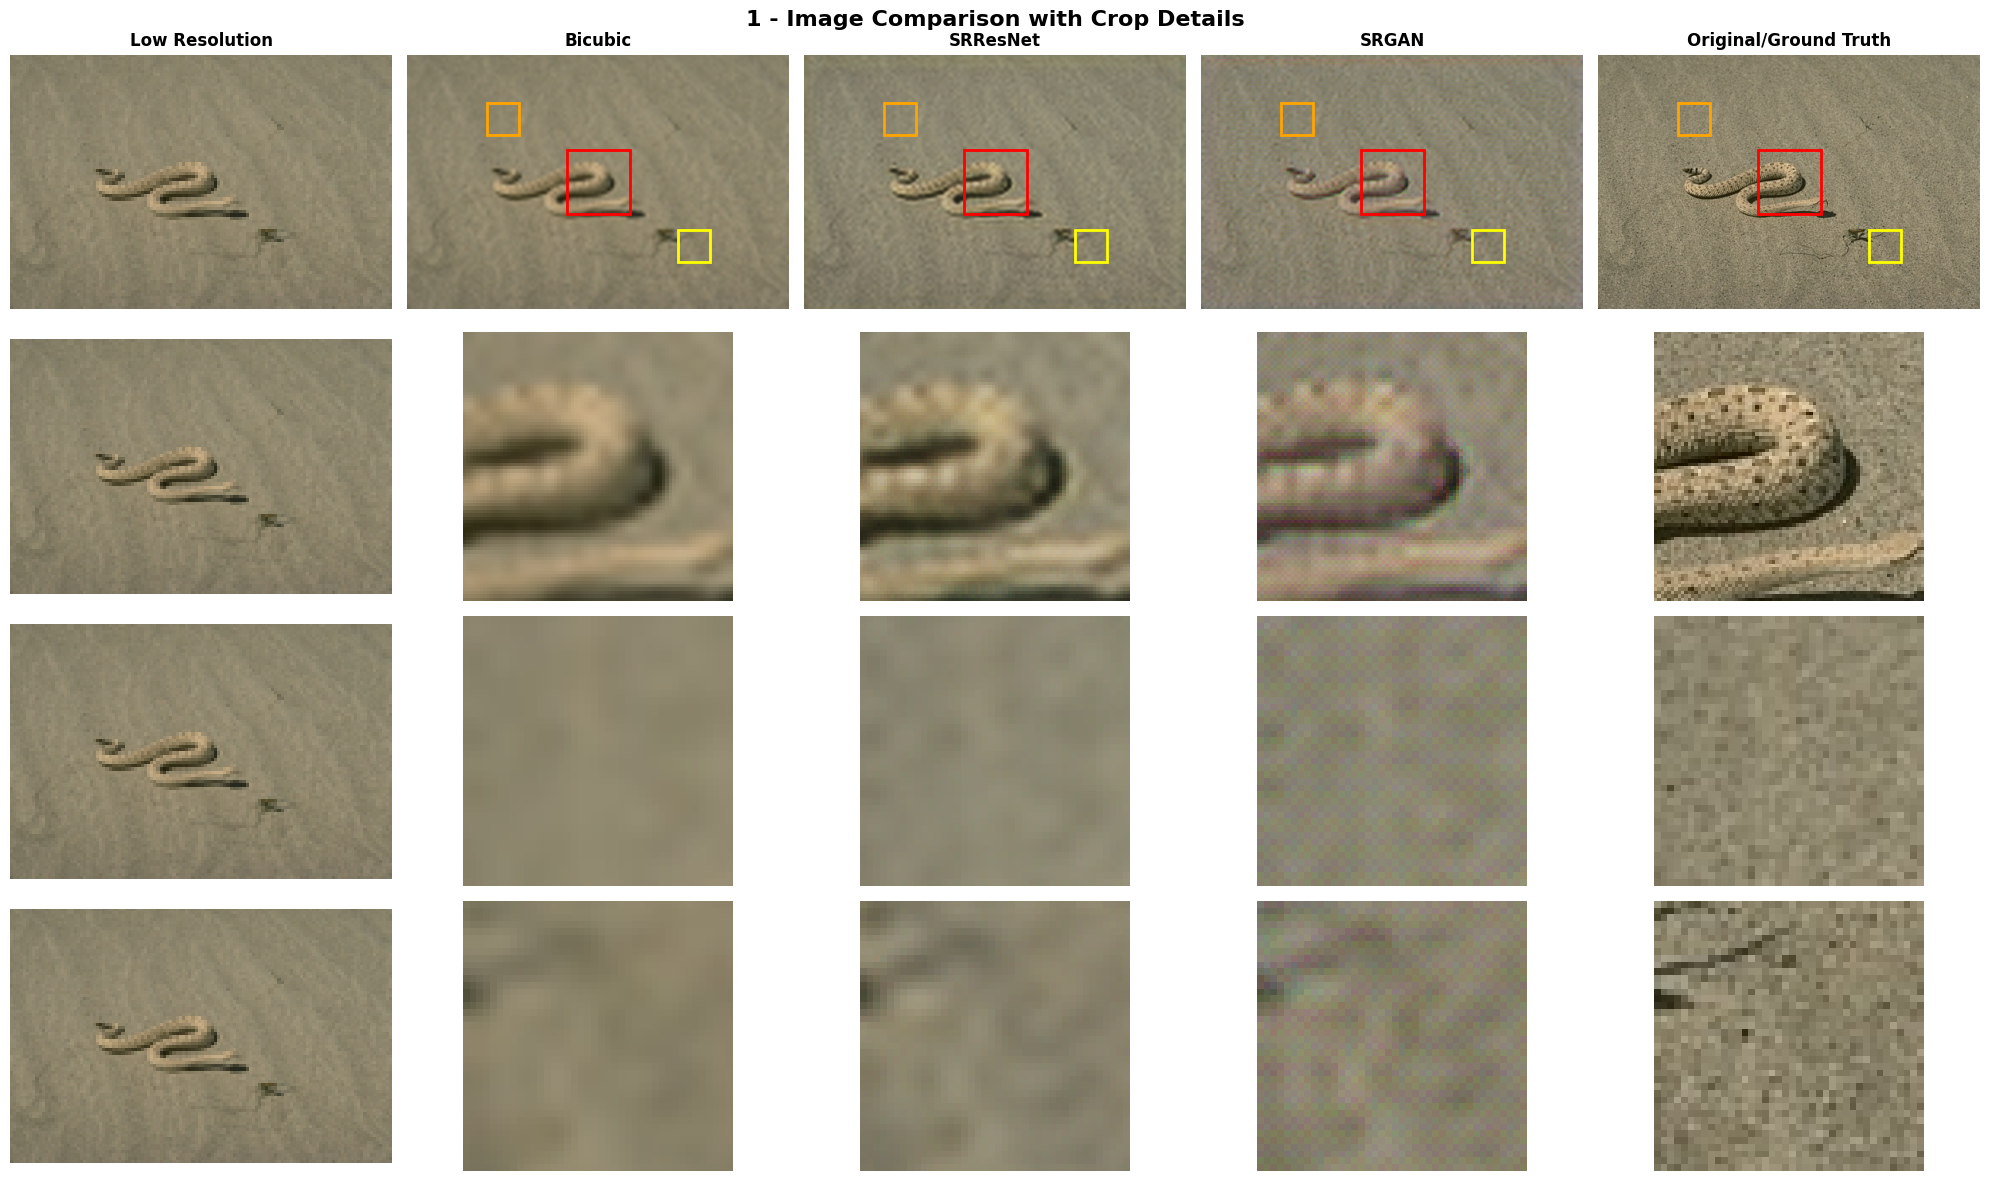

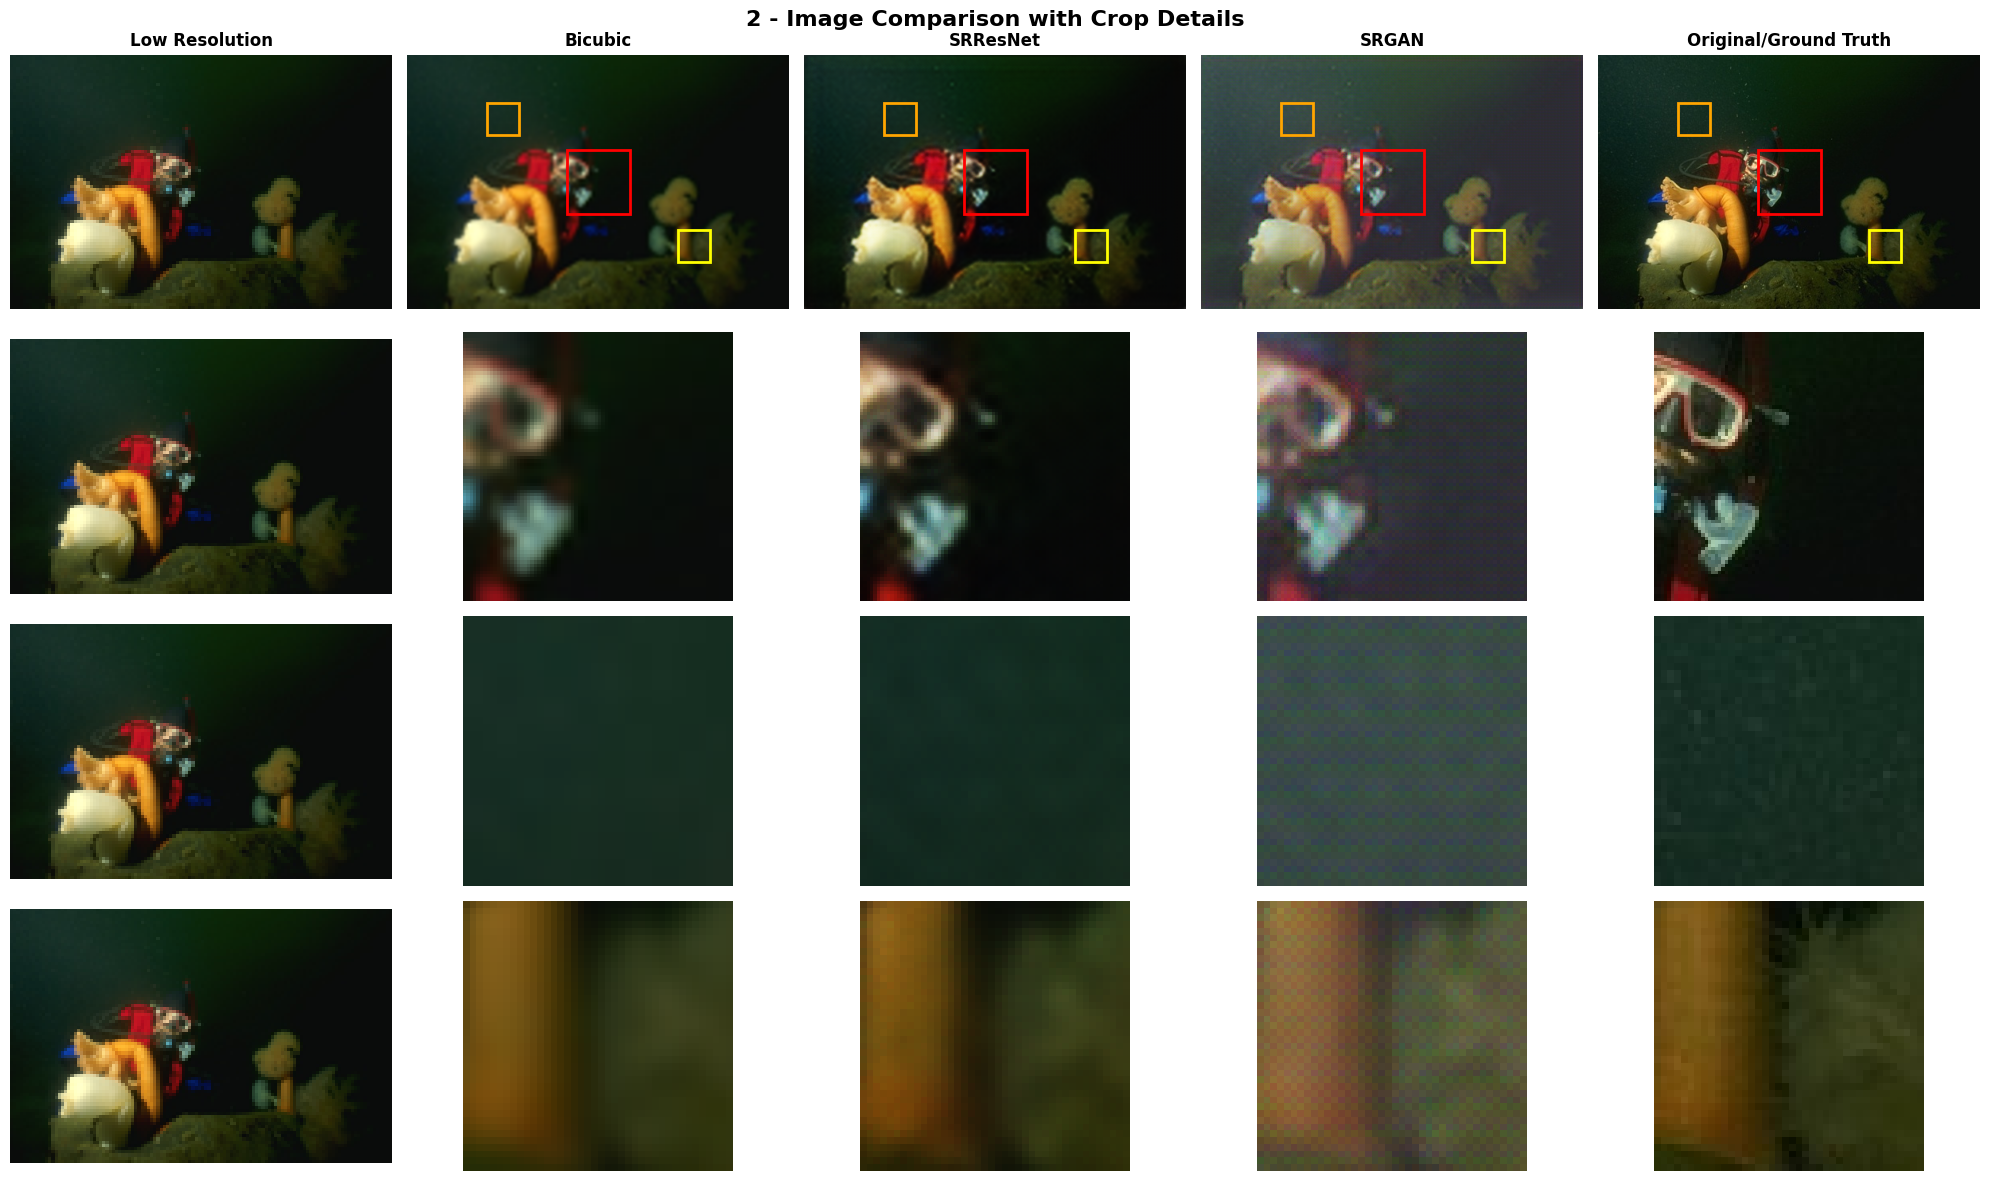

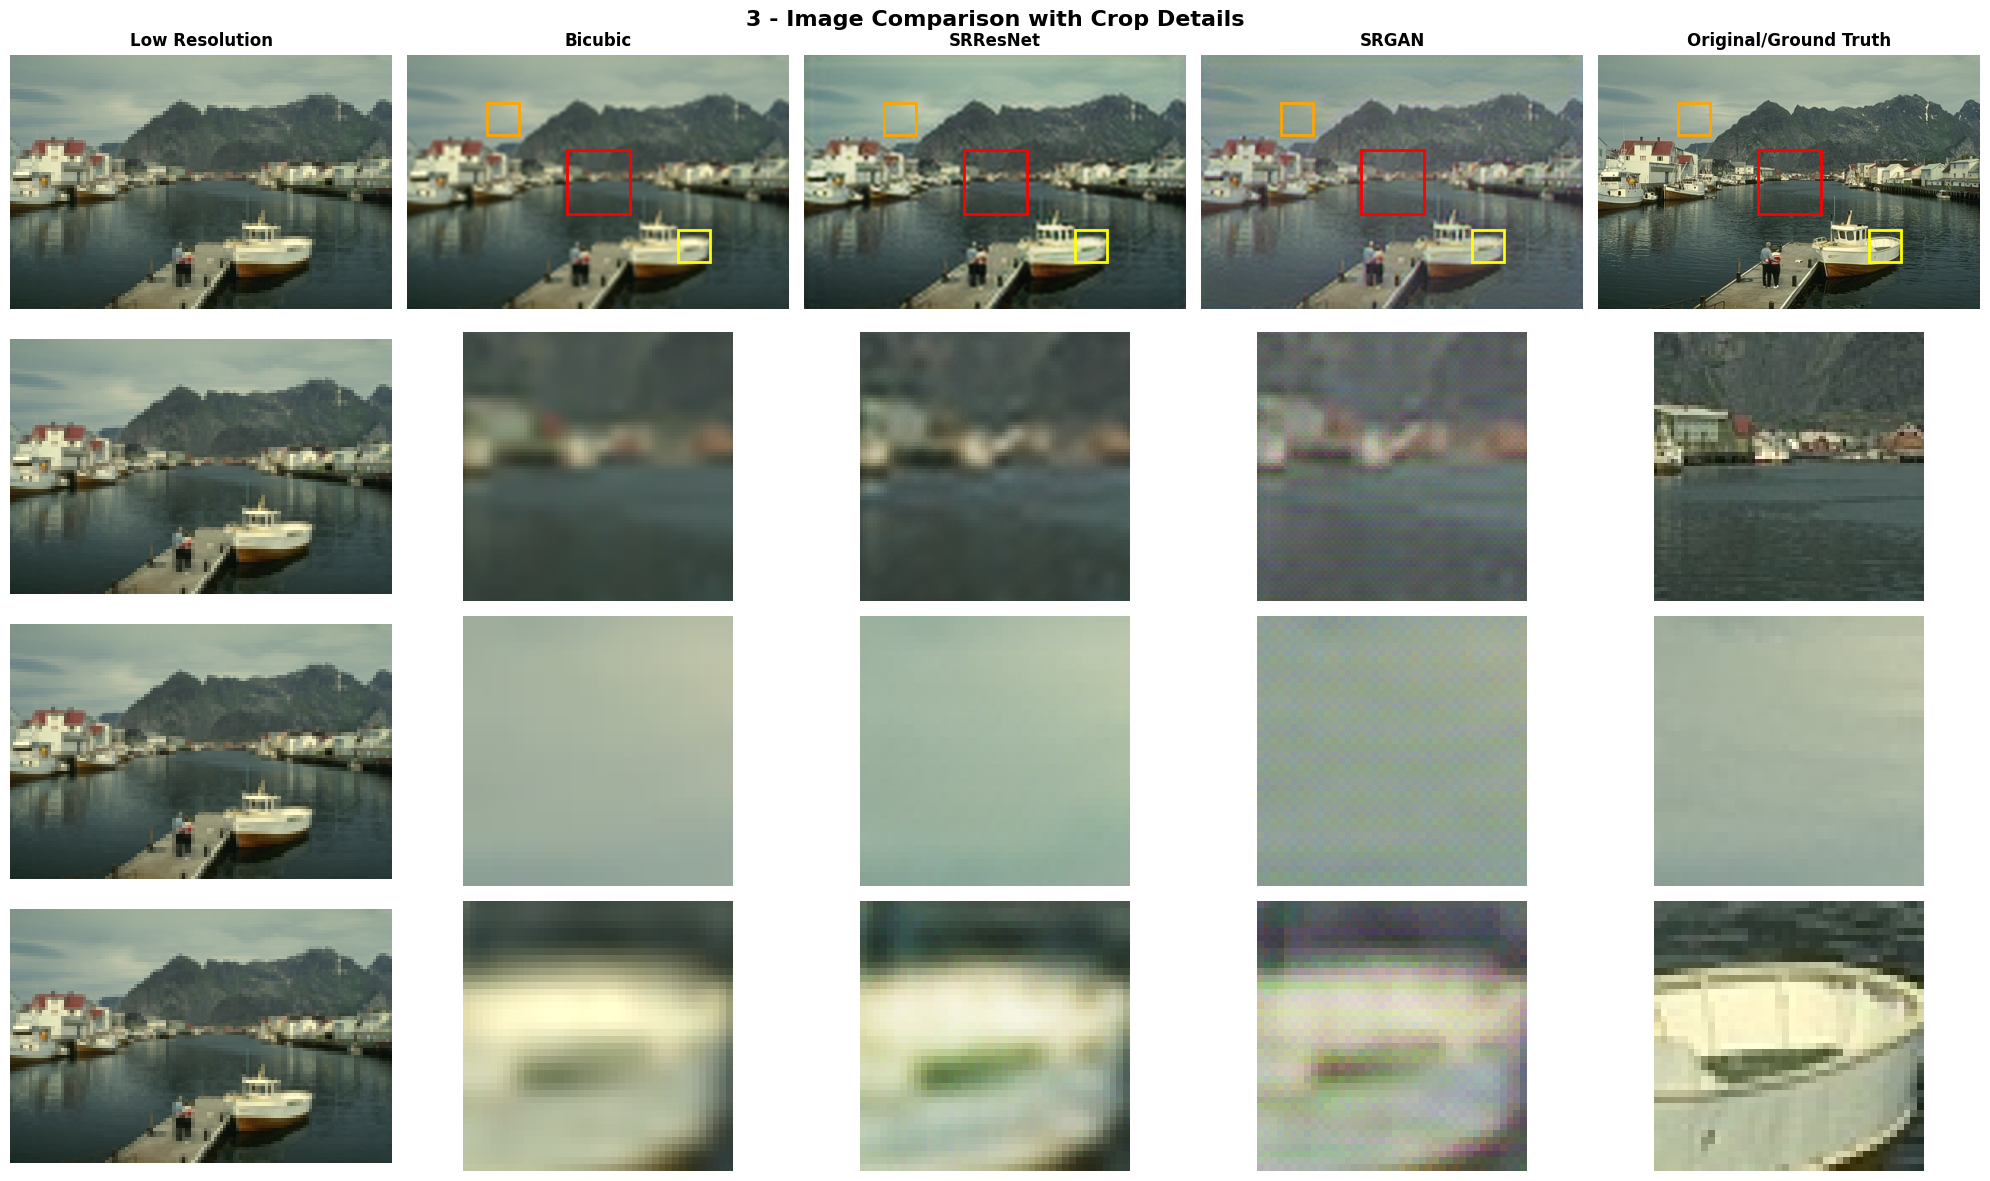

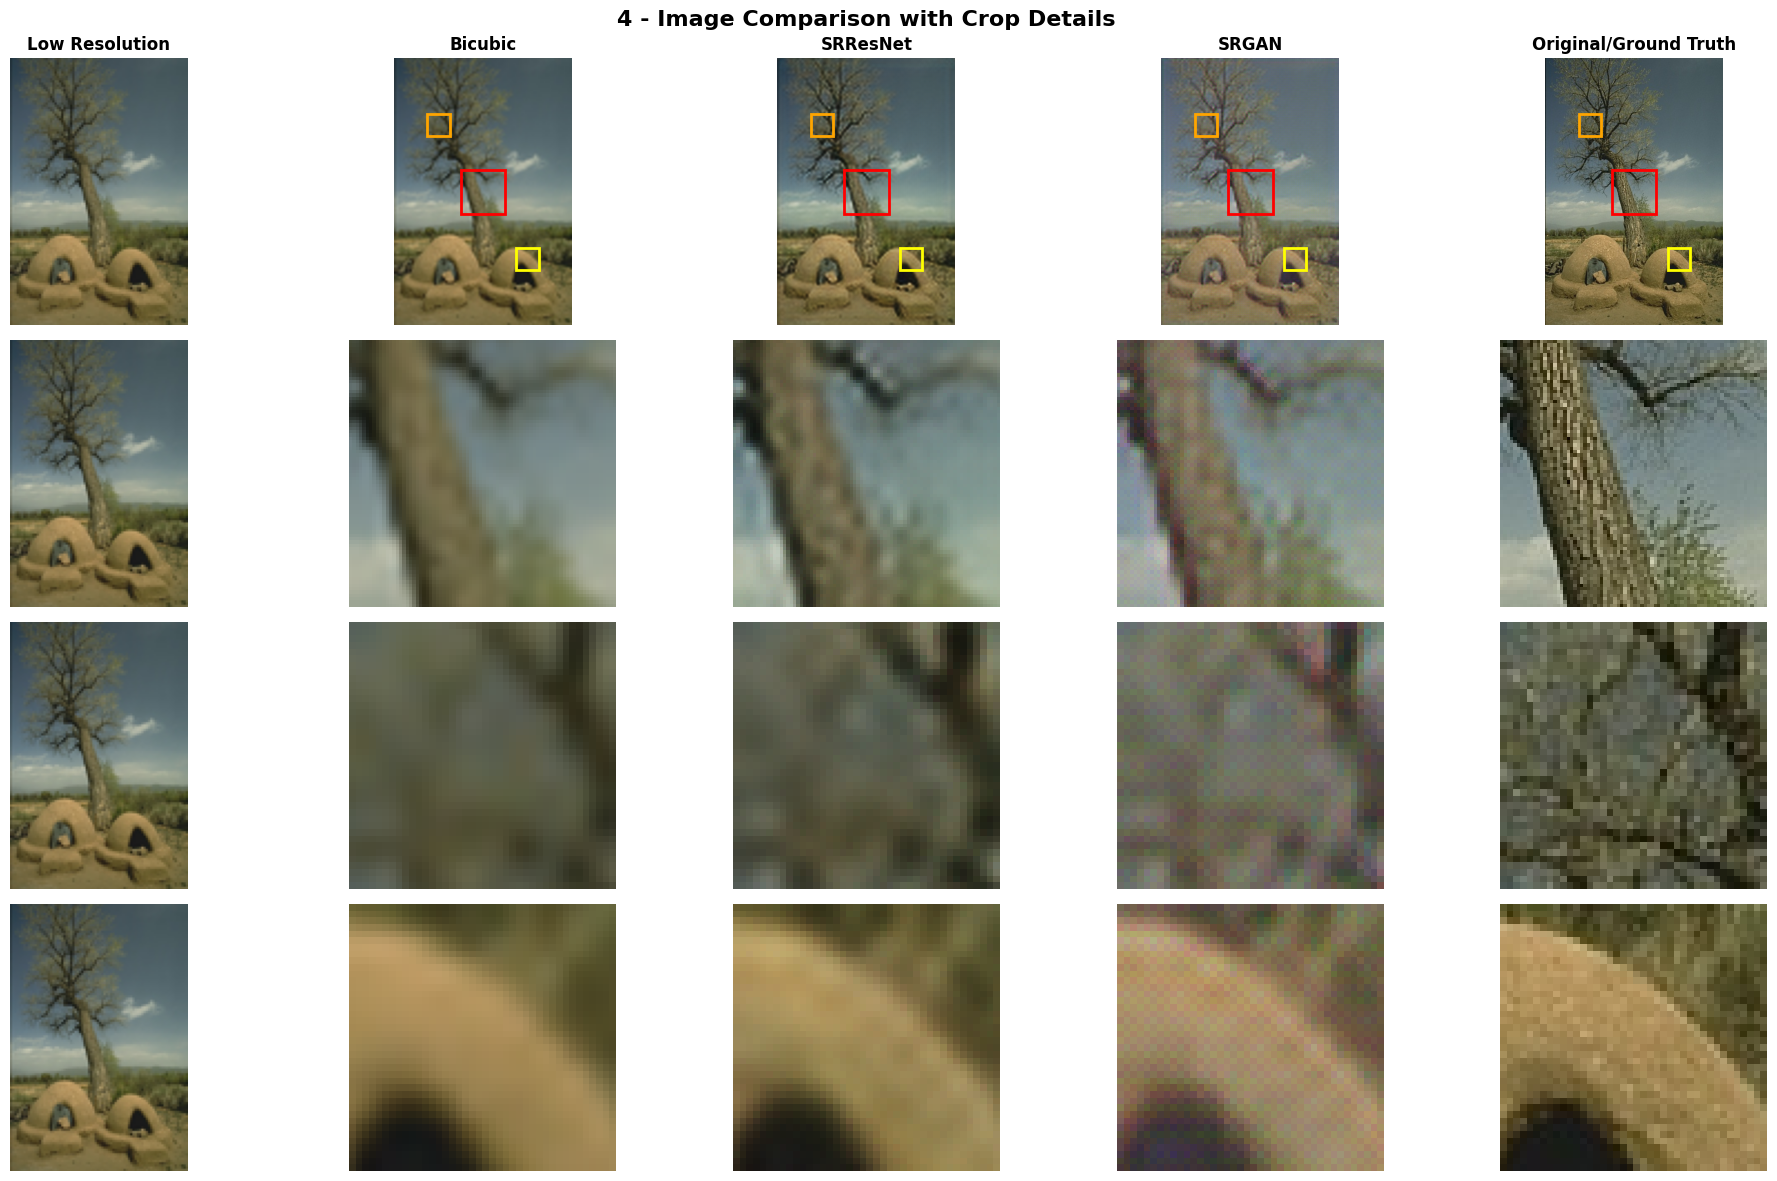

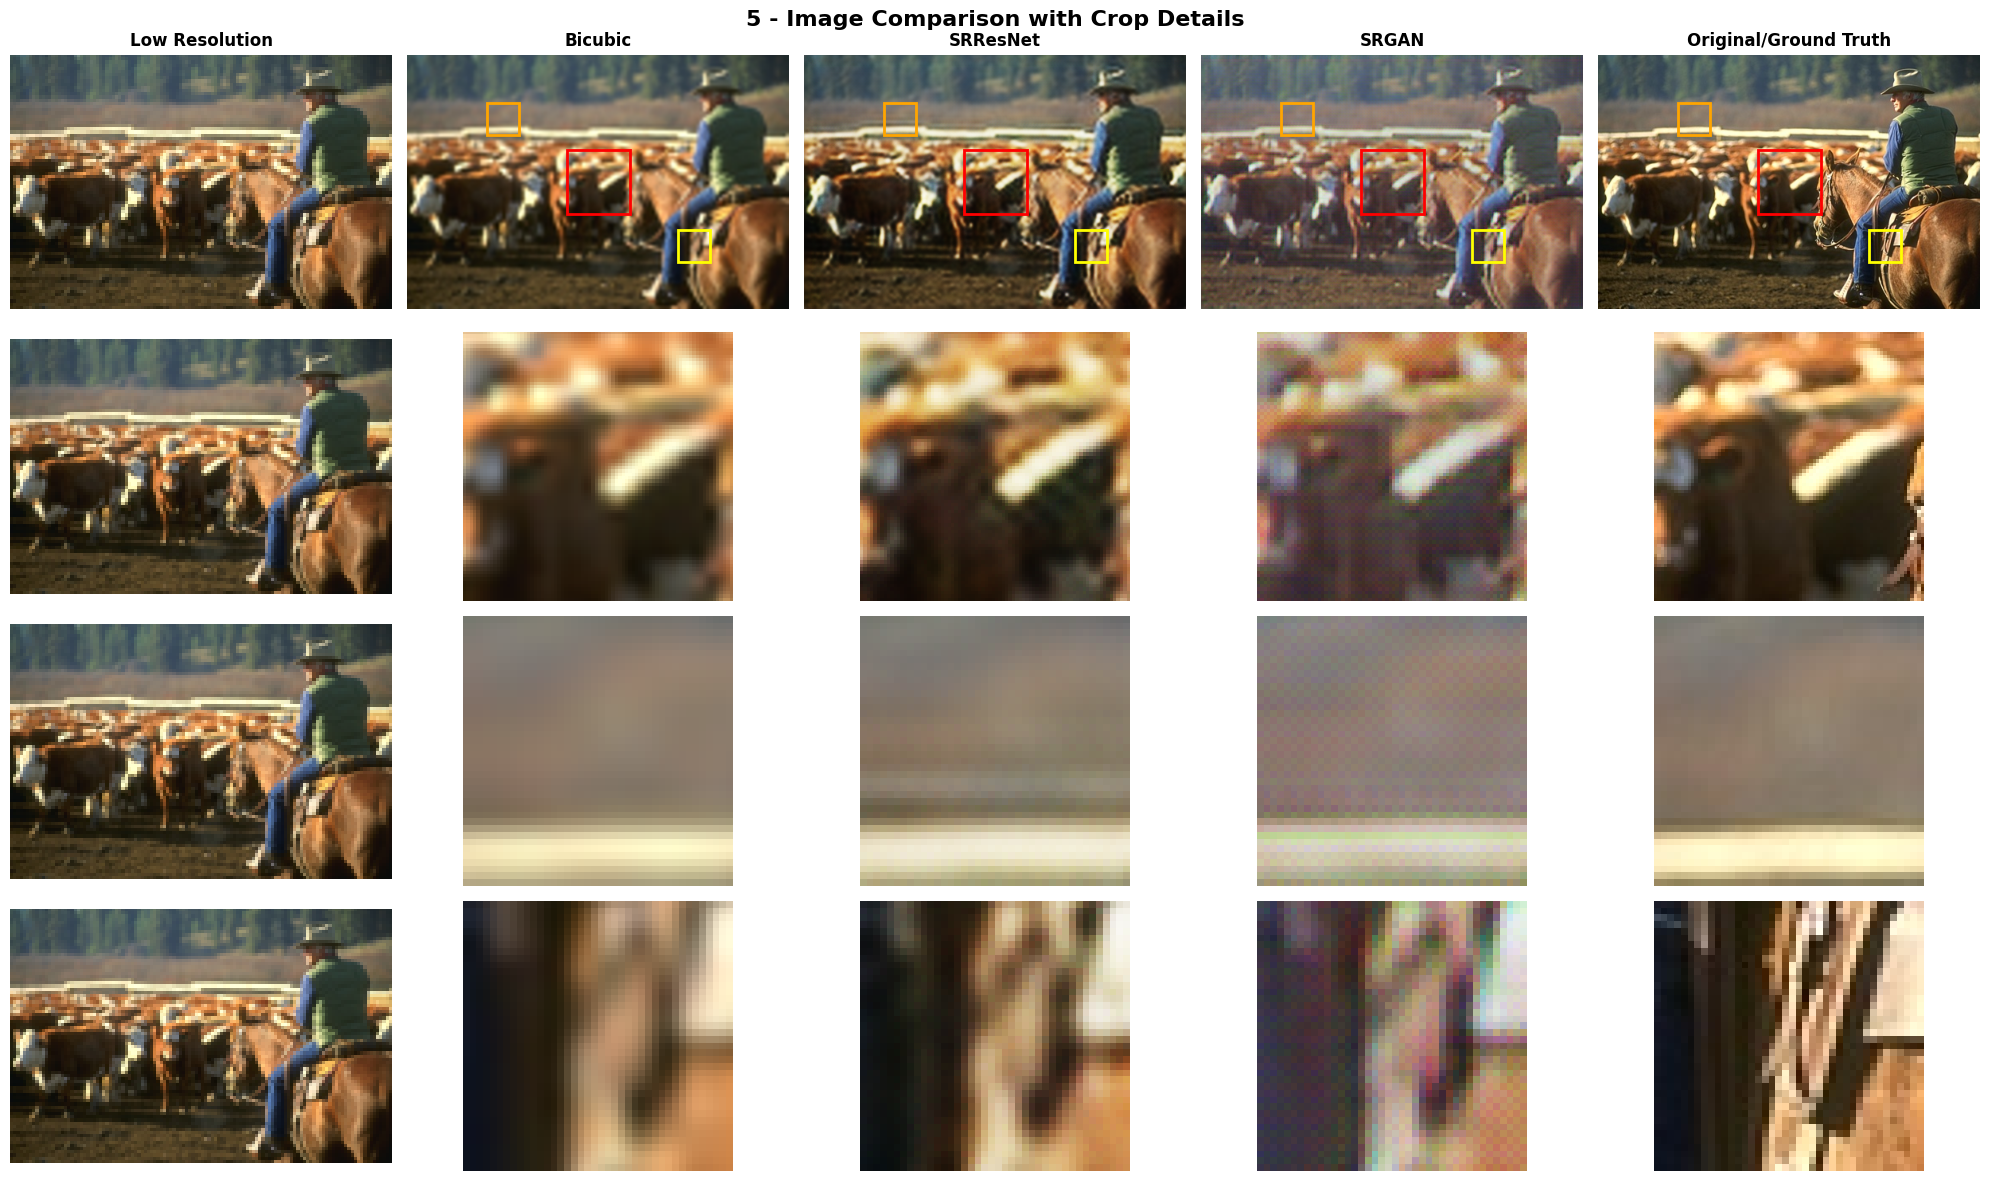

In [1]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from collections import defaultdict

# Set up the directory path
image_dir = "../results/results-bsd100-v2"

# Get all image files and group by base name AND method type
image_groups = defaultdict(lambda: defaultdict(list))

for filename in os.listdir(image_dir):
    if filename.endswith('.png'):
        # Extract parts: ['batch', 'evaluation', 'srgan/srresnet', '1', 'bicubic/lr/original/sr']
        parts = filename.split('_')
        if len(parts) >= 5:  # Ensure we have enough parts
            method_type = parts[2]  # 'srgan' or 'srresnet'
            base_name = parts[3]    # '1', '2', etc.
            variant = parts[4].replace('.png', '')  # 'bicubic', 'lr', 'original', 'sr'
            
            image_groups[base_name][method_type].append((variant, filename))

# Define the order of methods - updated to include both SR methods
method_order = ['lr', 'bicubic', 'srresnet_sr', 'srgan_sr', 'original']
method_labels = {
    'lr': 'Low Resolution',
    'bicubic': 'Bicubic', 
    'srgan_sr': 'SRGAN',
    'srresnet_sr': 'SRResNet',
    'original': 'Original/Ground Truth'
}

def load_image(filepath):
    """Load image without resizing"""
    img = Image.open(filepath)
    return np.array(img)

def create_crop_regions(img, regions):
    """Create cropped regions from an image"""
    crops = []
    for (x, y, w, h) in regions:
        crop = img[y:y+h, x:x+w]
        crops.append(crop)
    return crops

# Define crop regions (x, y, width, height) - you'll need to adjust these coordinates
crop_regions = [
    (50, 30, 80, 80),   # Top region (red box)
    (20, 120, 60, 60),  # Bottom left region (orange box)
    (100, 150, 60, 40)  # Bottom right region (yellow box)
]

# Define crop regions (x, y, width, height) - center-based cropping
def get_center_crop_regions(img_shape, crop_size=80):
    """Calculate center crop region coordinates"""
    img_h, img_w = img_shape[:2]
    center_x, center_y = img_w // 2, img_h // 2
    
    # Main center crop
    half_size = crop_size // 2
    center_crop = (center_x - half_size, center_y - half_size, crop_size, crop_size)
    
    # Additional crops around center (offset by quarter image size)
    offset_x, offset_y = img_w // 4, img_h // 4
    top_left = (center_x - offset_x - half_size//2, center_y - offset_y - half_size//2, half_size, half_size)
    bottom_right = (center_x + offset_x - half_size//2, center_y + offset_y - half_size//2, half_size, half_size)
    
    return [center_crop, top_left, bottom_right]

# Create visualization for each image group
for base_name in image_groups:
    # Organize files by method
    method_files = {}
    
    # Handle srgan and srresnet files
    for method_type in ['srgan', 'srresnet']:
        if method_type in image_groups[base_name]:
            for variant, filename in image_groups[base_name][method_type]:
                if variant == 'sr':
                    method_files[f'{method_type}_sr'] = filename
                else:
                    method_files[variant] = filename
    
    # Filter to only include methods we have files for
    available_methods = [method for method in method_order if method in method_files]
    
    if len(available_methods) < 2:  # Skip if we don't have enough images
        continue
    
    # Load all images first to determine crop regions
    images = {}
    for method in available_methods:
        img_path = os.path.join(image_dir, method_files[method])
        images[method] = load_image(img_path)
    
    reference_img = images.get('original')
    if reference_img is None:
        reference_img = images[available_methods[0]]
    crop_regions = get_center_crop_regions(reference_img.shape)
    
    # Create subplot with additional rows for crops
    n_crops = len(crop_regions)
    fig, axes = plt.subplots(n_crops + 1, len(available_methods), 
                            figsize=(4*len(available_methods), 3*(n_crops + 1)))
    
    if len(available_methods) == 1:
        axes = axes.reshape(-1, 1)
    
    # Display full images in first row
    for i, method in enumerate(available_methods):
        img = images[method]
        axes[0, i].imshow(img)
        axes[0, i].set_title(method_labels[method], fontsize=12, fontweight='bold')
        axes[0, i].axis('off')
        
        # Draw crop regions on full image (only for non-LR images)
        if method != 'lr':
            for j, (x, y, w, h) in enumerate(crop_regions):
                colors = ['red', 'orange', 'yellow', 'green', 'blue']
                color = colors[j % len(colors)]
                rect = plt.Rectangle((x, y), w, h, linewidth=2, edgecolor=color, facecolor='none')
                axes[0, i].add_patch(rect)
    
    # Display cropped regions in subsequent rows
    for crop_idx, (x, y, w, h) in enumerate(crop_regions):
        for i, method in enumerate(available_methods):
            img = images[method]
            
            # Skip cropping for LR images - show full image instead
            if method == 'lr':
                axes[crop_idx + 1, i].imshow(img)
            else:
                # Ensure crop coordinates are within image bounds
                img_h, img_w = img.shape[:2]
                x_end = min(x + w, img_w)
                y_end = min(y + h, img_h)
                x_start = max(0, min(x, img_w))
                y_start = max(0, min(y, img_h))
                
                # Only crop if we have valid dimensions
                if x_start < x_end and y_start < y_end:
                    crop = img[y_start:y_end, x_start:x_end]
                    axes[crop_idx + 1, i].imshow(crop)
                else:
                    # If crop region is invalid, show a placeholder
                    axes[crop_idx + 1, i].text(0.5, 0.5, 'Invalid\nCrop Region', 
                                              ha='center', va='center', transform=axes[crop_idx + 1, i].transAxes)
            axes[crop_idx + 1, i].axis('off')

    plt.suptitle(f'{base_name} - Image Comparison with Crop Details', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f"../results/results-organized/img-{base_name}_bsd_100.png", 
                bbox_inches='tight', dpi=300)
    plt.show()